In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time, warnings
warnings.filterwarnings("ignore")
# from utils import A_cluster
from tqdm.auto import tqdm
from torchvision import transforms, datasets
from copy import deepcopy
from spikingjelly.datasets.n_mnist import NMNIST

In [50]:
nmnist_train = NMNIST('./data/', train=True, data_type='frame', frames_number=20, split_by='number')
nmnist_test = NMNIST('./data/', train=False, data_type='frame', frames_number=20, split_by='number')
train_loader = torch.utils.data.DataLoader(dataset=nmnist_train, batch_size=256, shuffle=True, drop_last=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=nmnist_test, batch_size=256, shuffle=False, drop_last=False, num_workers=0)


The directory [./data/frames_number_20_split_by_number] already exists.
The directory [./data/frames_number_20_split_by_number] already exists.


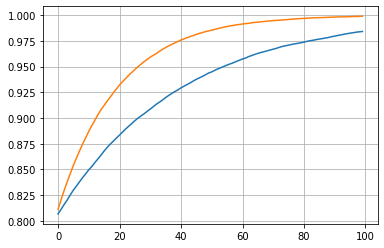

In [133]:
N = 256
dropout = 0.8

a = np.zeros((256, 256), dtype=int)
a[0:60, 0:60] = 1.
a[49:49+60, 49:49+60] = 1
a[98:98+60, 98:98+60] = 1
a[147:147+60, 147:147+60] = 1
a[196:196+60, 196:196+60] = 1

invalid_zeros = 1-(a==1).sum()/N**2
if invalid_zeros<dropout:
    b = np.array(np.random.rand(N, N) > (dropout-invalid_zeros)/(1-invalid_zeros), dtype=int) * (1-np.eye(N, N, dtype=int))
    c = a & b
else:
    c = a

log = []
for i in range(100):
    c = c& (np.array(np.random.rand(N, N) > 0.025, dtype=int) * (1-np.eye(N, N, dtype=int)))
    log.append((c==0).sum()/N**2)
plt.plot(log)


invalid_zeros = 1-(a==1).sum()/N**2
if invalid_zeros<dropout:
    b = np.array(np.random.rand(N, N) > (dropout-invalid_zeros)/(1-invalid_zeros), dtype=int) * (1-np.eye(N, N, dtype=int))
    c = a & b
else:
    c = a

log = []
for i in range(100):
    c = c& (np.array(np.random.rand(N, N) > 0.05, dtype=int) * (1-np.eye(N, N, dtype=int)))
    log.append((c==0).sum()/N**2)
plt.plot(log)

plt.grid()


In [137]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from main import RC, config
from spikingjelly.datasets.n_mnist import NMNIST

model_file = r'F:\GitHubClone\Reservoir-Computing\NMNIST\log\07-22-20-55\before-train-0-0-0.00.tar'
date = model_file.split('\log')[1][1:12]
model_parameter, mask = torch.load(model_file)

config.device = 'cpu'
model = RC().to(config.device)
model.load_state_dict(model_parameter)
print((mask[0]==0).sum().item()/config.hid**2)

nmnist_train = NMNIST('./data/', train=True, data_type='frame', frames_number=10, split_by='number')
nmnist_test = NMNIST('./data/', train=False, data_type='frame', frames_number=10, split_by='number')
train_loader = torch.utils.data.DataLoader(dataset=nmnist_train, batch_size=config.batch, shuffle=True, drop_last=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=nmnist_test, batch_size=config.batch, shuffle=False, drop_last=False, num_workers=0)

0.9
The directory [./data/frames_number_10_split_by_number] already exists.
The directory [./data/frames_number_10_split_by_number] already exists.


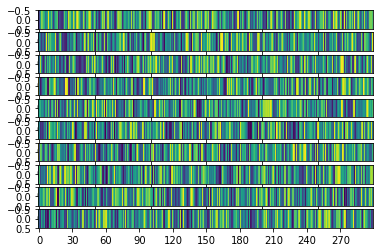

In [138]:
def plot(file='before-train'):
    # 统计每个神经元关于每一类别的平均发放率、加权平均发放率、读出层权重
    hid1_sum = torch.zeros(config.hid, config.output)
    for img, label in test_loader:
        out, sum1, sum2, Anorm, _, _ = model(img.to(config.device), [mask[0].to(config.device), mask[1].to(config.device)])
        for s,l in zip(sum1, label):
            hid1_sum[:, l.item()] += s.detach()
    hid1_sum = hid1_sum.numpy()

    for i in range(config.output):
        fig1 = plt.subplot(config.output,1,i+1)
        fig1.imshow([hid1_sum[:,i]])
        fig1.axis('tight')
    fig1.set_xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270])
    plt.savefig('./fig/'+date+'-'+file+'-firing.svg')

    for i in range(config.output):
        hid1_sum[:,i] = hid1_sum[:,i]*model.hid2_out.weight[i].detach().numpy()
    for i in range(config.output):
        fig1 = plt.subplot(config.output,1,i+1)
        fig1.imshow([hid1_sum[:,i]])
        fig1.axis('tight')
    fig1.set_xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270])
    plt.savefig('./fig/'+date+'-'+file+'-weighted-firing.svg')

    for i in range(config.output):
        fig1 = plt.subplot(config.output,1,i+1)
        fig1.imshow([model.hid2_out.weight.detach().numpy()[i,:]])
        fig1.axis('tight')
    fig1.set_xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270])
    plt.savefig('./fig/'+date+'-'+file+'-weight.svg')
plot(file='before-train')

In [90]:
a = torch.rand(30,30)
print(a.std(dim=0).sum())
print(a.std(dim=1).sum())


tensor(8.7343)
tensor(8.6924)


(-0.5, 299.5, 9.5, -0.5)

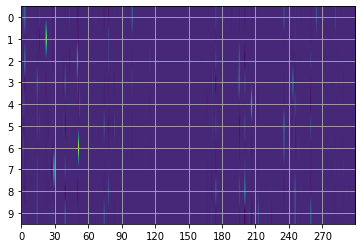

In [54]:
fig, ax = plt.subplots()
ax.imshow(hid1_sum[:,:].T)
ax.grid()
ax.set_xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270])
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.axis('tight')

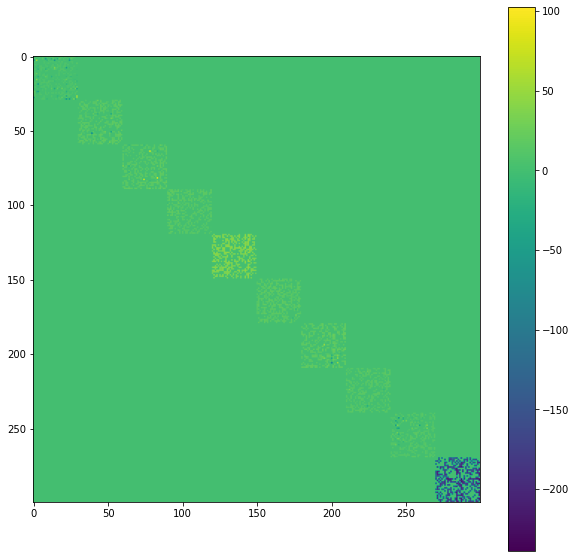

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(model.hid1_hid1.weight.detach().cpu().numpy()*mask[0].cpu().numpy()*100)
plt.colorbar()

In [11]:
hid1 = torch.zeros(config.hid, config.output).to(config.device)
hid1_1 = [[],[],[],[],[],[],[],[],[],[]]
for img, label in test_loader:
    
    out, sum1, sum2, Anorm, _, _ = model(img.to(config.device), [mask[0].to(config.device), mask[1].to(config.device)])
    for s,l in zip(sum1, label):
        # hid1[:,l.item()] += s
        hid1_1[l.item()].append(s.detach().numpy())
        # print(s.shape, l.item())
    
    # hid1[:,label] += sum1[0]
    # print(sum1)
    # print(label, img.shape)

In [21]:
# plt.imshow(hid1.detach().numpy())
# plt.savefig('./fig/firing.pdf')

In [20]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=config.seed, n_iter=2000, n_iter_without_progress=600)


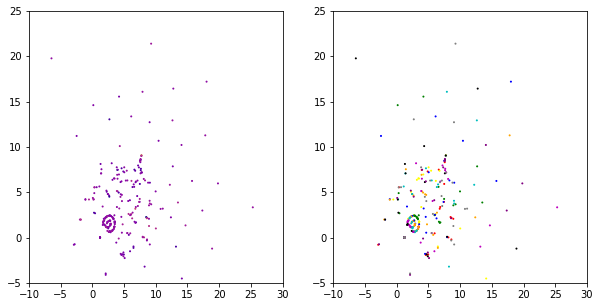

In [29]:
label = 6
X_embedded = tsne.fit_transform(np.array(hid1_1[label]).T)
# 考虑权重
importance = model.hid2_out.weight[label].detach().numpy()
importance = (importance-importance.min())/(importance.max()-importance.min())

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=importance, cmap='plasma', s=1, alpha=1)
plt.axis([-10,30,-5,25])
# plt.colorbar()

colors = ['red', 'yellow', 'green', 'blue', 'orange', 'c', 'm', 'black', 'purple', 'gray']
y = []
for i in range(config.hid):
    if i<30: y.append(0)
    elif i>=30 and i<60: y.append(1)
    elif i>=60 and i<90: y.append(2)
    elif i>=90 and i<120: y.append(3)
    elif i>=120 and i<150: y.append(4)
    elif i>=150 and i<180: y.append(5)
    elif i>=180 and i<210: y.append(6)
    elif i>=210 and i<240: y.append(7)
    elif i>=240 and i<270: y.append(8)
    elif i>=270 and i<300: y.append(9)
plt.subplot(122)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=[colors[label] for label in y], s=1, alpha=1)
plt.axis([-10,30,-5,25])
plt.savefig('./fig/tSNE-label-{:d}-weight.pdf'.format(label))

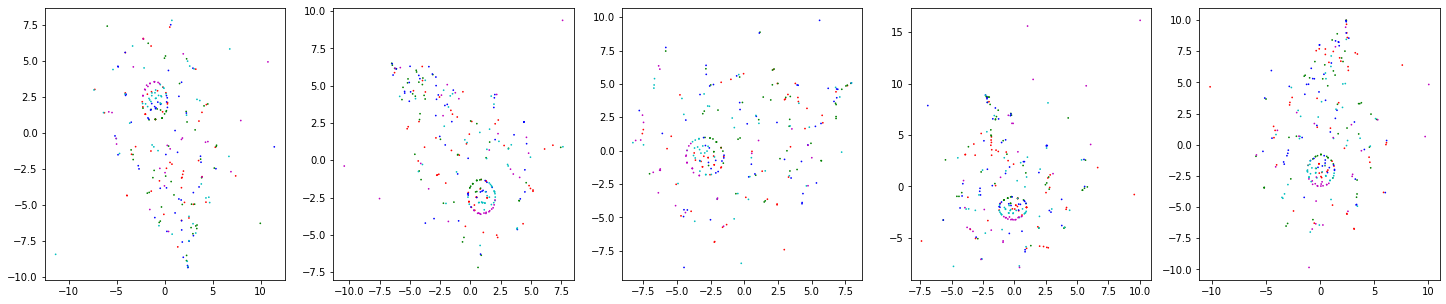

In [9]:
colors = ['r', 'g', 'b', 'c', 'm']
y = []
for i in range(config.hid):
    if i<55: y.append(0)
    elif i>=55 and i<110: y.append(1)
    elif i>=110 and i<165: y.append(2)
    elif i>=165 and i<220: y.append(3)
    elif i>=220: y.append(4)


plt.figure(figsize=(25,5))
X_embedded = tsne.fit_transform(np.array(hid1_1[0]).T)
plt.subplot(151)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=[colors[label] for label in y], s=0.5)

X_embedded = tsne.fit_transform(np.array(hid1_1[1]).T)
plt.subplot(152)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=[colors[label] for label in y], s=0.5)

X_embedded = tsne.fit_transform(np.array(hid1_1[2]).T)
plt.subplot(153)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=[colors[label] for label in y], s=0.5)

X_embedded = tsne.fit_transform(np.array(hid1_1[3]).T)
plt.subplot(154)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=[colors[label] for label in y], s=0.5)

X_embedded = tsne.fit_transform(np.array(hid1_1[4]).T)
plt.subplot(155)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=[colors[label] for label in y], s=0.5)

plt.savefig('./fig/tSNE-label-01234.pdf')
plt.show()